# Verifying That Datasets Are Correct

In [97]:
import tensorflow as tf

from data_paths import data_paths, data_config
from utils.dataset_utils import AudioData
from models.unet.unet_wrapped import AmpDbSpectLayer, AmpDbToAudioLayer, STFTLayer, ISTFTLayer
from utils.spectrogram_utils import SpectUtils
from models.unet.unet import OurUNet
from models.unet.test_unet_spec import model_spec
import tensorflow_io as tfio

In [9]:
train_data = tf.data.Dataset.load(data_paths["spectrograms"]["train"])
test_data = tf.data.Dataset.load(data_paths["spectrograms"]["test"])

In [61]:
# data = AudioData(clean_audio_path=data_paths["clean"]["train"],
#                  clean_audio_test_path=data_paths["clean"]["test"],
#                  noisy_audio_path=data_paths["noise"]["train"],
#                  noisy_audio_test_path=data_paths["noise"]["test"],
#                  sampling_rate=data_config["sample_rate"],
#                  hop_length=data_config["hop_length"],
#                  noise_level=data_config["noise_level"],
#                  clean_vec_repeats=data_config["clean_vec_repeats"],
#                  frame_length=data_config["frame_length"],
#                  fft_length=data_config["fft_length"])

spectutils = SpectUtils(
    sampling_rate=data_config["sample_rate"],
    hop_length=data_config["hop_length"],
    frame_length=data_config["frame_length"],
    fft_length=data_config["fft_length"]
)

stft_config = {
    "hop_length" : data_config["hop_length"],
    "noise_level" : data_config["noise_level"],
    "frame_length" : data_config["frame_length"],
    "fft_length" : data_config["fft_length"],
    "window_func" : tf.signal.hann_window
}

stft_config_str = {
    "hop_length" : data_config["hop_length"],
    "noise_level" : data_config["noise_level"],
    "frame_length" : data_config["frame_length"],
    "fft_length" : data_config["fft_length"],
    "window_func" : "Hann Window"
}

In [18]:
mixed_ex_spect = None
clean_ex_spect = None
for mixed_spect, clean_spect in train_data.take(1):
    mixed_ex_spect = mixed_spect
    clean_ex_spect = clean_spect

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Example mixed spectrogram'}, xlabel='Time'>)

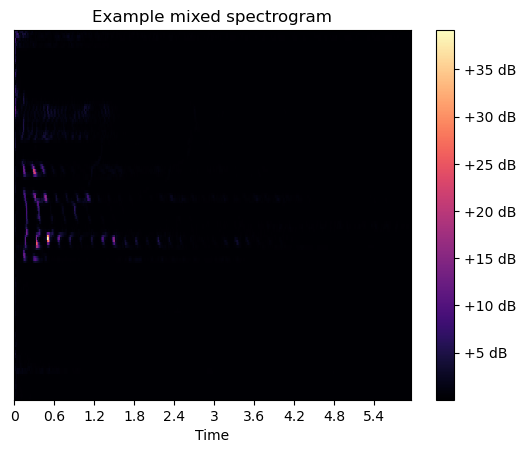

In [19]:
spectutils.display_intensity_spectrogram(mixed_ex_spect, "Example mixed spectrogram")

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Example clean spectrogram'}, xlabel='Time'>)

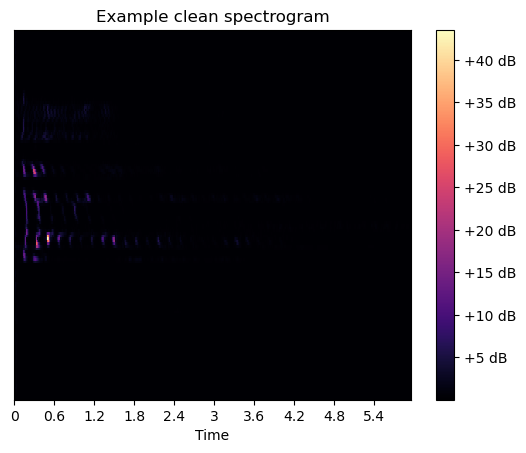

In [20]:
spectutils.display_intensity_spectrogram(clean_ex_spect, "Example clean spectrogram")

In [21]:
amp_spect_to_audio = AmpDbToAudioLayer(
    stft_config=stft_config,
    dB=False
)

In [23]:
recov_clean = amp_spect_to_audio(clean_ex_spect)

In [24]:
recov_mixed = amp_spect_to_audio(mixed_ex_spect)

In [25]:
spectutils.save_numpy_as_wav(recov_clean, "./example_clean_recovered_no_unet.wav")
spectutils.save_numpy_as_wav(recov_mixed, "./example_mixed_recovered_no_unet.wav")

# Model: One Epoch

For this run, the model was trained for a single epoch using Adam at a learning rate of 1/10th Adam's default in Keras: 0.0001. Details about the specifics of the short-time Fourier transform are below.

In [58]:
import json

In [64]:
print(json.dumps(data_config, indent=4))

{
    "data_folder_path": "./data",
    "folder_name": "MS-SNSD",
    "sample_rate": 16000,
    "hop_length": 256,
    "noise_level": 0.1,
    "frame_length": 1024,
    "fft_length": 1024,
    "clean_vec_repeats": 1
}


In [51]:
import pickle

The history for this training session was lost due to an error in file paths (the model weights saved over the history object). However, this would have been a rather uninteresting history: there was only one epoch!

In [29]:
# Loading a blank model
unetbuilder = OurUNet()
unet = unetbuilder.build_model(modelspec=model_spec)

In [30]:
# Verifying that the blank model was loaded
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   160         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 dropout (Dropout)              (None, None, None,   0           ['conv2d[0][0]']                 
                                16)                                                           

In [33]:
unet.load_weights("/home/spandan/projects_new/audio-denoising-csc487/model_saves/unet01")

In [35]:
mixed_ex_spect.shape

TensorShape([141, 513])

In [41]:
mixed_ex_spect_expanded = tf.expand_dims(tf.expand_dims(mixed_ex_spect, axis=-1), axis=0)

In [42]:
mixed_ex_spect_expanded.shape

TensorShape([1, 141, 513, 1])

In [44]:
prediction_spect = unet.predict(mixed_ex_spect_expanded)

1/1 [==============================] - 0s 108ms/step


In [46]:
prediction_spect_trimmed = tf.squeeze(prediction_spect)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Example prediction spectrogram'}, xlabel='Time'>)

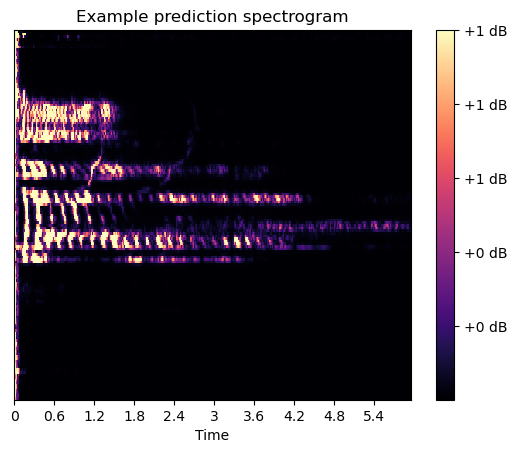

In [47]:
spectutils.display_intensity_spectrogram(prediction_spect_trimmed, "Example prediction spectrogram")

In [48]:
predicted_clean = amp_spect_to_audio(prediction_spect_trimmed)

This particular example did not have its noise removed. The human voice is robotic, indicating that phase information was lost during the training process.

In [50]:
spectutils.save_numpy_as_wav(predicted_clean, "./example_prediction.wav")

### Experimentation with Other Audio Clips
We could be running into one of the edge cases: audio clips that are simply too short. Let's try loading a longer audio file, as well as a more prominent noise--in particular, a 13-second clip of a male voice overlaid over a vacuum cleaner.

In [65]:
longer_audio_vect = spectutils.load_into_numpy("data/MS-SNSD/clean_test/clnsp75.wav")
longer_audio_noise = spectutils.load_into_numpy("data/MS-SNSD/noise_test/VacuumCleaner_1.wav")

longer_mixed = spectutils.clean_noise_mixer(
    longer_audio_vect, 
    longer_audio_noise
)

In [66]:
amp_spect_from_audio = AmpDbSpectLayer(stft_config=stft_config, dB=False)
longer_mixed_spect = amp_spect_from_audio(longer_mixed)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Example longer mixed spectrogram'}, xlabel='Time'>)

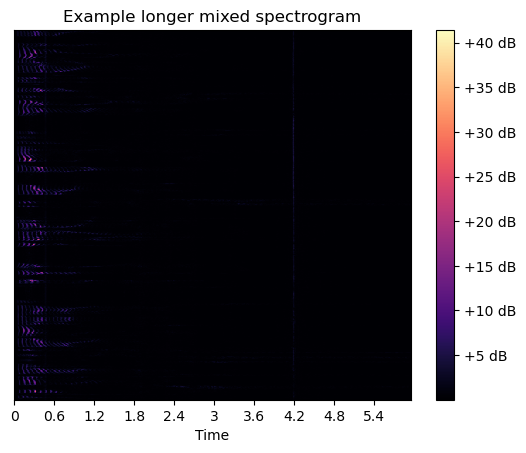

In [68]:
spectutils.display_intensity_spectrogram(longer_mixed_spect, "Example longer mixed spectrogram")

Here's a prediction function that handles all of the dimensional oddities and accepts any UNet for a prediction:

In [74]:
def predict_on_using(mixed_spect, unet, path):
    mixed_spect_expanded = tf.expand_dims(tf.expand_dims(mixed_spect, axis=-1), axis=0)
    prediction_spect = unet.predict(mixed_spect_expanded)
    prediction_spect_trimmed = tf.squeeze(prediction_spect)
    spectutils.display_intensity_spectrogram(prediction_spect_trimmed, "Prediction spectrogram")
    predicted_clean = amp_spect_to_audio(prediction_spect_trimmed)
    spectutils.save_numpy_as_wav(predicted_clean, path)
    return predicted_clean

In [76]:
spectutils.save_numpy_as_wav(longer_mixed, "./unet01_longer_prediction_mixed.wav")

1/1 [==============================] - 0s 441ms/step


<tf.Tensor: shape=(210944,), dtype=float32, numpy=
array([0.0000000e+00, 9.5204393e-11, 4.0860620e-11, ..., 4.5123492e-08,
       2.2448559e-08, 6.1386802e-09], dtype=float32)>

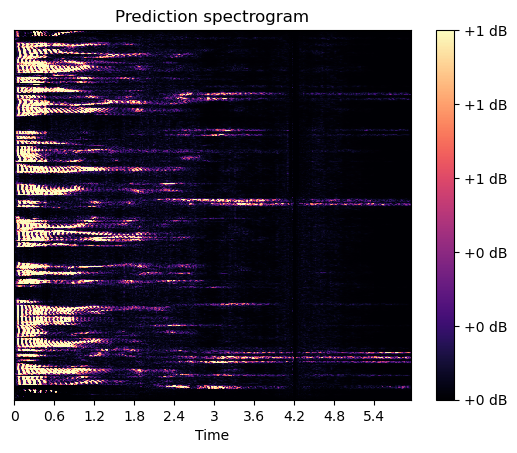

In [75]:
predict_on_using(longer_mixed_spect, unet, "./unet01_longer_prediction.wav")

The voice remains *terribly* robotic, indicating loss of phase information again. Applying the Griffin-Lim algorithm to a result of a UNet doesn't seem to work well, and this is, in fact, somewhat intuitive: even the smallest local disturbances can *entirely* destroy phase information, to a point beyond recovery by the Griffin-Lim algorithm.

### More Epochs?

First, we can try training for as many epochs as early stopping will allow. I set the target epoch number to be 10. With this configuration, early stopping triggers after epoch 3. Something interesting is that MAE values *do* continue to improve; this may suggest that it's beneficial to remove early stopping and see where training for a ludicrous number of epochs takes us.

In [80]:
unetbuilder = OurUNet()
unet = unetbuilder.build_model(modelspec=model_spec)
unet.load_weights("./model_saves/unet10")

1/1 [==============================] - 0s 299ms/step


<tf.Tensor: shape=(210944,), dtype=float32, numpy=
array([0.0000000e+00, 2.0995822e-10, 4.8096488e-10, ..., 5.1129721e-08,
       2.2022936e-08, 5.2410978e-09], dtype=float32)>

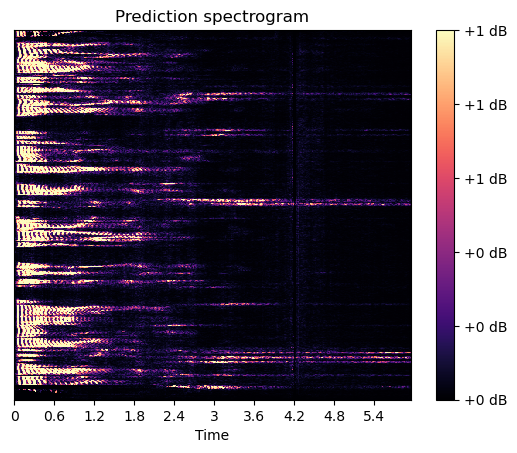

In [92]:
predict_on_using(longer_mixed_spect, unet, "./unet03_longer_prediction.wav")

Only *slightly* more noise was removed. Phase information still remains destroyed. To ensure this is not just due to a misimplementation of the Griffin-Lim algorithm, we can try running Griffin-Lim on just the mixed spectrogram:

In [82]:
recovered_longer_mixed_spect_no_net = amp_spect_to_audio(longer_mixed_spect)
spectutils.save_numpy_as_wav(recovered_longer_mixed_spect_no_net, "./longer_mixed_no_net.wav")

Unfortunately, it sounds like the issue is absolutely our model--and *not* a shortcoming of phase approximation methods. It makes sense that the network would not aim to approximate phases well; there was no information in the labels that made this clear! The model was simply provided an amplitude spectrogram and told to learn the mapping, without explicitly being asked to capture phase details of the training label.

We can try bumping up the iteractions of the Griffin-Lim algorithm.

In [87]:
class AmpDbToAudioLayerMoreIters(tf.keras.layers.Layer):
    def __init__(self, stft_config, dB = False, halve = False, iters = 30):
        super(AmpDbToAudioLayerMoreIters, self).__init__()
        self.stft_config = stft_config
        self.dB = dB
        self.iters = iters
        self.halve = halve
    
    def call(self, inputs, *args, **kwargs):
        # super.__call__(args, kwargs) # TODO: correct?

        if(self.dB):
            inputs = _db_to_amp_tensorflow(inputs)
        
        if(self.halve):
            inputs = 0.5 * inputs

        # TODO: remove 0.5?
        # TODO: params could be different
        output = tfio.audio.inverse_spectrogram(
            spectrogram=inputs,
            nfft=self.stft_config["fft_length"],
            window=self.stft_config["frame_length"],
            stride=self.stft_config["hop_length"],
            iterations=self.iters
        )

        return output

In [88]:
def predict_on_using_more_iters(mixed_spect, unet, path):
    amp_spect_to_audio = AmpDbToAudioLayerMoreIters(
        stft_config=stft_config,
        dB = False,
        iters=100
    )
    mixed_spect_expanded = tf.expand_dims(tf.expand_dims(mixed_spect, axis=-1), axis=0)
    prediction_spect = unet.predict(mixed_spect_expanded)
    prediction_spect_trimmed = tf.squeeze(prediction_spect)
    spectutils.display_intensity_spectrogram(prediction_spect_trimmed, "Prediction spectrogram")
    predicted_clean = amp_spect_to_audio(prediction_spect_trimmed)
    spectutils.save_numpy_as_wav(predicted_clean, path)
    return predicted_clean

1/1 [==============================] - 0s 231ms/step


<tf.Tensor: shape=(210944,), dtype=float32, numpy=
array([0.0000000e+00, 7.9606183e-11, 3.8887910e-10, ..., 3.7767432e-08,
       1.8777476e-08, 4.8075655e-09], dtype=float32)>

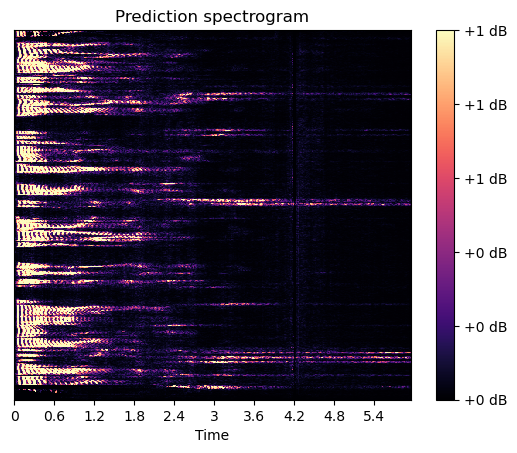

In [94]:
predict_on_using_more_iters(longer_mixed_spect, unet, "./unet03_longer_prediction_more_gl_iters.wav")

This produces VERY *slight* clarity improvement. 

In [95]:
unetbuilder = OurUNet()
unet = unetbuilder.build_model(modelspec=model_spec)
unet.load_weights("./model_saves/unet10/unet10")

1/1 [==============================] - 0s 407ms/step


<tf.Tensor: shape=(210944,), dtype=float32, numpy=
array([0.0000000e+00, 8.2099322e-10, 1.8590076e-09, ..., 7.8972446e-09,
       3.1690481e-09, 1.1103136e-09], dtype=float32)>

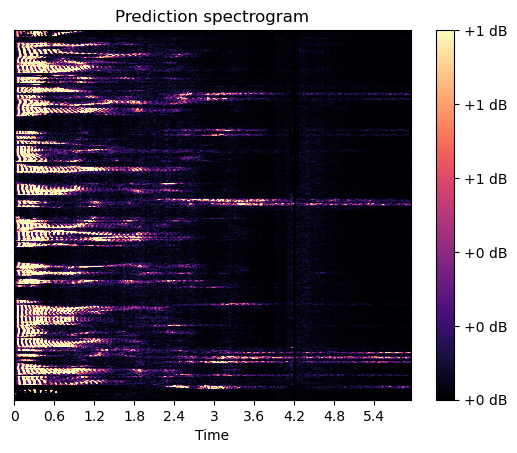

In [96]:
predict_on_using_more_iters(longer_mixed_spect, unet, "./unet03_longer_prediction_more_gl_iters_folder.wav")

## Trying Complex Inputs

Before we train a model using complex inputs, we would like to try and bring a complex spectrogram back, to ascertain whether we can do so without the added obstacle of the model's approximations and radical edits.

In [111]:
stft = STFTLayer(stft_config=stft_config)
istft = ISTFTLayer(stft_config=stft_config)

In [112]:
complex_spect = stft(longer_mixed)

In [113]:
real_component = tf.math.real(complex_spect)
imag_component = tf.math.imag(complex_spect)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Real component'}, xlabel='Time'>)

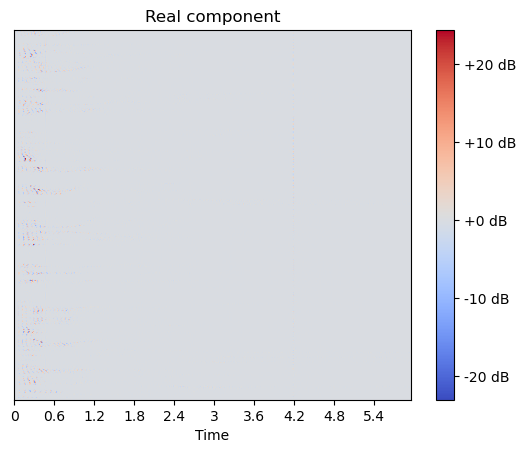

In [115]:
spectutils.display_intensity_spectrogram(real_component, "Real component")

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Imaginary component'}, xlabel='Time'>)

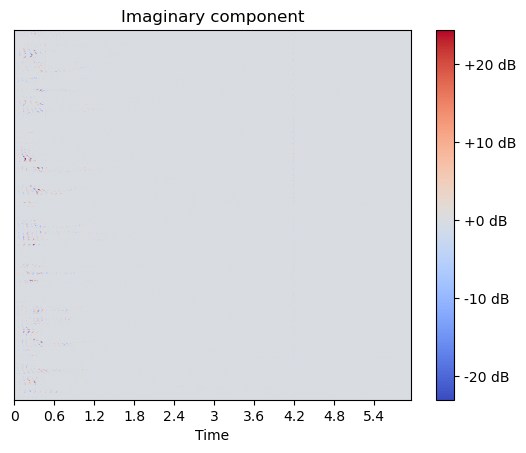

In [116]:
spectutils.display_intensity_spectrogram(real_component, "Imaginary component")

In [118]:
recovered_from_complex = istft(complex_spect)
spectutils.save_numpy_as_wav(recovered_from_complex, "./recovered_from_unseparated_complex.wav")

This recovery works. Let's try recovering from the SEPARATED components.

In [121]:
recovered_from_sep_complex = istft(tf.dtypes.complex(real_component, imag_component))
spectutils.save_numpy_as_wav(recovered_from_sep_complex, "./recovered_from_separated_complex.wav")

This recovery also works! We can now attempt to provide the model two-channel input.

Tensors can be stacked to produce two-channel (2 in the *final* component) inputs:

In [139]:
teststack = tf.expand_dims(tf.stack([real_component, imag_component], -1), axis=0)
teststack.shape

TensorShape([1, 821, 513, 2])

In [141]:
teststack_trimmed = tf.squeeze(teststack)
teststack_trimmed.shape

TensorShape([821, 513, 2])

In [142]:
teststack_real = teststack_trimmed[:, :, 0]
teststack_imag = teststack_trimmed[:, :, 1]

In [143]:
teststack_real.shape

TensorShape([821, 513])

The spectrograms and their labels now have two channels!


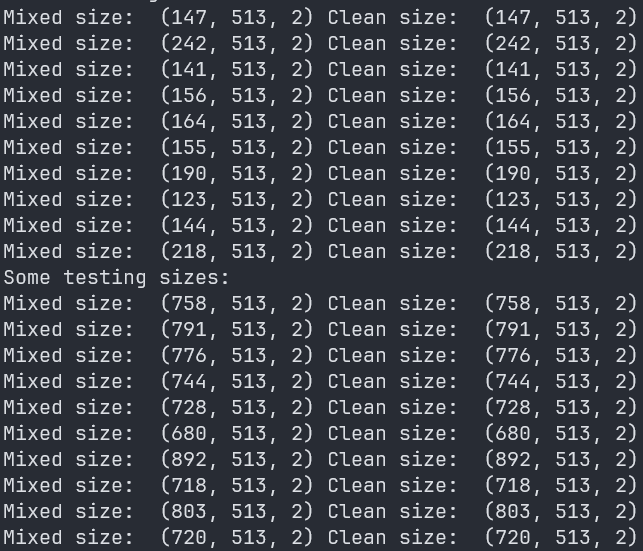

The unet definition in models/unet was adapted to unet_complex, a unet that takes in two-channel 2D tensors. The Adam optimizer's learning rate was maintained at 0.0001, and all other settings were not changed. This training round exhibited lower MSE loss values (for all previous runs, loss values stablized at 1.2--this time, they began at around 0.8 and decreased steadily).

The most obvious thing lacking from the amplitude-only network was phase information. Hopefully, that is maintained here.

In [127]:
from models.unet import unet_complex

In [128]:
unet_complex_builder = unet_complex.OurUNet()
unet_complex = unet_complex_builder.build_model(modelspec=model_spec)

The most fundamental change in the following summary is the shift from one-channel inputs (None, None, None, 1) to two-channel inputs (None, None, None, 2).

In [129]:
unet_complex.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 2)]                                                              
                                                                                                  
 conv2d_66 (Conv2D)             (None, None, None,   304         ['input_7[0][0]']                
                                16)                                                               
                                                                                                  
 dropout_30 (Dropout)           (None, None, None,   0           ['conv2d_66[0][0]']              
                                16)                                                         

In [130]:
unet_complex.load_weights("model_saves/unet_complex/unet_complex")

In [133]:
complex_spect.shape

TensorShape([821, 513])

In [144]:
def predict_on_using_complex(complex_spect, unet, path):
    real = tf.math.real(complex_spect)
    imag = tf.math.imag(complex_spect)
    dual_channel = tf.stack([real, imag], -1)
    mixed_spect_expanded = tf.expand_dims(dual_channel, axis=0)
    prediction_spect = unet.predict(mixed_spect_expanded)
    prediction_spect_trimmed = tf.squeeze(prediction_spect)
    prediction_spect_real = prediction_spect_trimmed[:, :, 0]
    prediction_spect_imag = prediction_spect_trimmed[:, :, 1]
    spectutils.display_intensity_spectrogram(prediction_spect_real, "Prediction spectrogram, real")
    spectutils.display_intensity_spectrogram(prediction_spect_imag, "Prediction spectrogram, imaginary")
    predicted_clean = istft(tf.dtypes.complex(prediction_spect_real, prediction_spect_imag))
    # predicted_clean = amp_spect_to_audio(prediction_spect_trimmed)
    spectutils.save_numpy_as_wav(predicted_clean, path)
    return predicted_clean

1/1 [==============================] - 0s 362ms/step


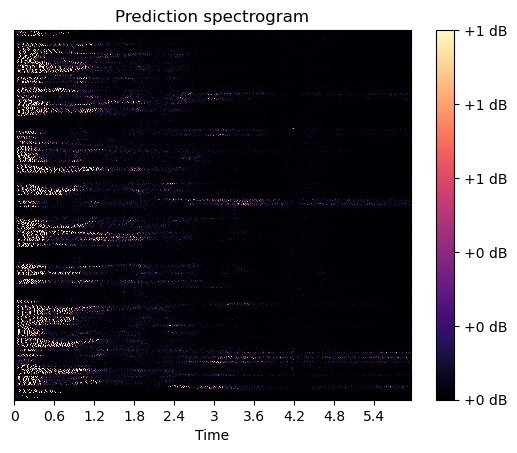

In [137]:
complex_prediction = predict_on_using_complex(complex_spect, unet_complex, "./complex_prediction.wav")

The voice continues to sound robotic, even with the complex phase information. The vacuum in the background *is indeed obscured*, however, which is rather exciting.

A final step might be to train using

## Trying Decibels

An easy change that produces radically different circumstances is attempt to use decibel spectrograms, to more clearly differentiate audio features for the net. At this point, training and testing spectrograms were fully regenerated with data_loader_layers.py using a decibel encoding.